# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=291065 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukebirkett/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukebirkett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/lukebirkett/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['i', 'want', 'to', 'correct', 'what', 'i', 'wrote', ...], 'pos')


# A. Re-Useable Code and Functions

In [5]:
def preprocess_text(token_list: list, stop_words: list):
    """
    Applies case normalization, removes numbers and punctuation, 
    and removes stopwords from a list of tokens.

    Args:
        token_list (list): The input list of tokens (strings).
        stop_words (set/list): A collection of words to be removed (stopwords).

    Returns:
        list: The preprocessed list of tokens.
    """
    
    processed_list = [
        token.lower()
        for token in token_list  
        if token.isalpha()        # removes numbers and punctuation
        and token.lower() not in stop_words  # remove tokens in stop_words (by keeping those not in stop_words)
    ]
    
    return processed_list

# 1. Generating Positive and Negative Word Lists

a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

## Code (a & b)

In [6]:
stop = stopwords.words('english')

pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for rev,label in training_data:

    # PREPROCESSING: case, number, punctuation, stopword
    rev = preprocess_text(token_list=rev, stop_words=stop)

    # FreqDist() data structure
    if label == 'pos':
        pos_freq_dist.update(rev) 
    elif label == 'neg':
        neg_freq_dist.update(rev)
    else: 
        print("unexpected class")

# IDENTIFY WORD DIFFERENTIAL BETWEEN CLASSSES
all_words = set(pos_freq_dist.keys()) | set(neg_freq_dist.keys()) # all unique words

word_counts = []

for word in all_words:
    pos_count = pos_freq_dist.get(word, 0)
    neg_count = neg_freq_dist.get(word, 0)
    difference = pos_count - neg_count
    total = pos_count + neg_count
    word_counts.append((word, difference, total))

# IDENTIFY REVIEW DOMAIN STOP WORDS
word_counts_copy = list(word_counts)
word_counts_copy.sort(key=lambda item: item[2], reverse=True) # [2] = Total Corpus Count
_domainStopWords = word_counts_copy[:5] # 5 most common review words
domainStopWords = [word for word, diff, total in _domainStopWords]
domain_stop_set = set(domainStopWords)

# DROP DOMAIN WORDS FROM LIST
final_word_counts = [word for word in word_counts if word[0] not in domain_stop_set]

# SORY BY [1], THE CLASS/LABEL DIFFERENTIAL
final_word_counts.sort(key=lambda item: item[1]) # low to high

# COLLECT WORDS WITH THE LARGEST DIFFERENTIAL
_negative_word_list = final_word_counts[:10] # first 10
_positive_word_list = final_word_counts[-10:] # last 10

_positive_word_list.sort(key=lambda item: item[1], reverse=True) # high to low

negative_word_list = [word for word, diff, total in _negative_word_list]
positive_word_list = [word for word, diff, total in _positive_word_list]

In [7]:
print(domainStopWords)

['film', 'movie', 'one', 'like', 'even']


In [8]:
print(negative_word_list)

['bad', 'plot', 'nothing', 'worst', 'script', 'stupid', 'boring', 'least', 'supposed', 'harry']


In [9]:
print(_negative_word_list)

[('bad', -476, 998), ('plot', -244, 1040), ('nothing', -153, 555), ('worst', -139, 205), ('script', -127, 533), ('stupid', -114, 174), ('boring', -113, 195), ('least', -107, 447), ('supposed', -105, 223), ('harry', -105, 163)]


In [10]:
print(positive_word_list)

['life', 'also', 'great', 'well', 'best', 'story', 'many', 'world', 'love', 'first']


In [11]:
print(_positive_word_list)

[('life', 329, 1113), ('also', 327, 1395), ('great', 263, 833), ('well', 253, 1315), ('best', 245, 931), ('story', 229, 1555), ('many', 203, 901), ('world', 201, 729), ('love', 200, 800), ('first', 166, 1318)]


## Explanation (c) (Word Count: 309)

In this code I am looping through each review in the training data whilst giving myself access to its wordslists and label. For each wordlist, I preprocess and normalise accounting for case, numbers, punctuation and stopwords. I am doing this to remove noise and get access to the words in their cleanest and more contextualised form and removing words devoid of meaningful context. I did not implement any stemming or lemmanisation as the goal is to obtain a sentiment word list, hence, readability is desirable. 

After pre-processing the wordlists, I am appending the wordlists into pre-initalised `FreqDists` (dicts). The goal here is to obtain a count of all words used in the corpus split by their review’s sentiment label.

Using the built-in functionality of Set’s in Python, I can obtain a list of all unique words found in the corpus. Combining this unique list with the positive and negative `FreqDists`, I calculate the differential between positive and negative occurrences of each word, as well, the total occurrence count. Words that come out with a positive differential are candidates for the positive world list, and negative ones the negative word list.

I use the total occurrence count to identify words that appear to be “domain stop words”. These are words that appear to be used more frequently in the context of writing reviews as if they are domain specific stop words. The sheer frequency of these words mean they lose the context they might otherwise hold in general usage. The list I found, which I limited to 5 entries, was `'film', 'movie', 'one', 'like', 'even'`. 

Finally, I take a list of all the words in the corpus and sort them by the differential metric. A slice of the first 10 entries gives me the most negative words and a slice of the final 10 gives me the most positive words. 


# 2. Word List Classifer

a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


## Code

In [12]:
def sentiment_weight_converter(sentiment_word_list: list):
    """
    Takes a sentiment word list with frequency counts converts it into a Sentiment Polarity weightings.  

    Args:
        sentiment_word_list (Iterable): Nested word list comprised of word:string, differential: int and total:int. 
        
    Returns:
        dict: dictionary of word and its sentiment weighting
    """
    sentiment_weights = {
        word: differential / total_usage
        for word, differential, total_usage in sentiment_word_list
    }

    return sentiment_weights

In [13]:
print(sentiment_weight_converter(_positive_word_list))

{'life': 0.29559748427672955, 'also': 0.23440860215053763, 'great': 0.3157262905162065, 'well': 0.19239543726235742, 'best': 0.2631578947368421, 'story': 0.1472668810289389, 'many': 0.2253052164261931, 'world': 0.2757201646090535, 'love': 0.25, 'first': 0.125948406676783}


In [14]:
print(sentiment_weight_converter(_negative_word_list))

{'bad': -0.47695390781563124, 'plot': -0.23461538461538461, 'nothing': -0.2756756756756757, 'worst': -0.6780487804878049, 'script': -0.23827392120075047, 'stupid': -0.6551724137931034, 'boring': -0.5794871794871795, 'least': -0.23937360178970918, 'supposed': -0.47085201793721976, 'harry': -0.6441717791411042}


In [15]:
from nltk.classify.api import ClassifierI

class ReviewClassifer(ClassifierI):

    def __init__(self, pos, neg):
        self._pos = sentiment_weight_converter(pos)
        self._neg = sentiment_weight_converter(neg)

    def classify(self, words):
        score = 0

        for word in words:
            
            if word in self._pos:
                score += self._pos[word]

            elif word in self._neg:
                score += self._neg[word]

        return "neg" if score <= 0 else "pos"

    def labels(self):
        return ("pos", "neg")

In [16]:
#Example usage:

classifier = ReviewClassifer(_positive_word_list, _negative_word_list)

data = [
    training_data[100], 
    training_data[500],
    training_data[700],
    training_data[1100]
]

for rev,label in data:
    rev = preprocess_text(token_list=rev, stop_words=stop)

    cls = classifier.classify(rev)

    print(label, cls)

pos pos
pos neg
neg pos
neg neg


## Explanation (Word Count: 326)

Here I have set up a list classifer class by inheriting from `ClassifierI` in the `nltk` package. 

This has been done to for standardization purpose to follow convention and for customization later in the assignment where I can easily knit `nltks` eval packages.

Prior to writting the class I set up a function called `sentiment_weight_converter`. This function allows me to take my sentiment word list (pos or neg) and calculate a weighting for each word. The idea is to capture which words are more positive or negative.

I had previously calculated the differential for each word to determine the most positive or negative words, as well as, counting the overall total frequency for each word. By taking a ratio of each per word, the score its weighted by how much the sentiment skew covers the total usage of a work

- If a word is used 100 times and all seen instances are negative then it has a weighting of 1
- If a word is used 100 times but only 80 instances are negative and 20 positive it has a differential of 60 and a weighting of 60/100 = 0.2. It is still considered a negative word but less so.

$$\text{Weighting Score} = \frac{D}{T}$$

Hopefully this approach will lead to an improve in some evaluation scores. Additionally, positive words overall seem to appear with more frequences but the negative weights appear to come out stronger so this may even find out and make classifcation better.

Within the class, the `classify` method handles the computation. Looping through a review, if it sees a word in either sentiment list then the words correponding **weight** is added the `score` tally which is initalized as 0. Note, by definition negative words will have negative weights and visa versa for positive words, meaning each will pull the `score` in either direction. Finally after the loop has finished the method returns 'neg' if the score <= 0 or positive if  >0.

# 3. Evaluation Metrics

a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

## Code

In [17]:
import nltk
from nltk.metrics import precision, recall, f_measure
from nltk.classify.util import accuracy
from collections import defaultdict

stop = nltk.corpus.stopwords.words('english')

classifier = ReviewClassifer(_positive_word_list, _negative_word_list)

refsets = defaultdict(set) # init store for actual labels
testsets = defaultdict(set) # init store for predicted labels

# PROCCESS, PREDICT AND STORE
for i, (words, label) in enumerate(testing_data):
    
    processed_words = preprocess_text(token_list=words, stop_words=stop)
    
    predicted_label = classifier.classify(processed_words)
    
    refsets[label].add(i)
    testsets[predicted_label].add(i)

# CALCULATE ACCURACY
acc = nltk.classify.util.accuracy(
    classifier, 
    [(preprocess_text(words, stop), label) for words, label in testing_data]
)

print("-" * 30)
print(f"Overall Accuracy: {acc:.4f}")
print("-" * 30)

print("-" * 30)
print(f"Evaluation Metrics")
print("-" * 30)

# CALCULATE PRECISION, RECALL, F1-SCORE
for label in classifier.labels():
    
    # PRECISION: OF DOCUMENTS CLASSIFIED AS X, HOW MANY WERE ACTUALLY X
    P = precision(refsets[label], testsets[label])
    
    # RECALL: OF DOCUMENTS THAT ARE ACTUALLY X, HOW MANY WERE CLASSIFIED AS X
    R = recall(refsets[label], testsets[label])
    
    # F1-SCORE: The HARMONIC MEAN OF PRECISION AND RECALL
    F = f_measure(refsets[label], testsets[label])
    
    print(f"Metrics for Class '{label}':")
    print(f"  Precision: {P:.4f}")
    print(f"  Recall:    {R:.4f}")
    print(f"  F1-Score:  {F:.4f}")
    print("-" * 30)

------------------------------
Overall Accuracy: 0.7100
------------------------------
------------------------------
Evaluation Metrics
------------------------------
Metrics for Class 'pos':
  Precision: 0.6583
  Recall:    0.8733
  F1-Score:  0.7507
------------------------------
Metrics for Class 'neg':
  Precision: 0.8119
  Recall:    0.5467
  F1-Score:  0.6534
------------------------------


## Explanation (Word Count: 475)

Accuracy tells us the ratio of correct samples, irrespective of class. However, an important condition for its use is class balance. Failure to achieve this can lead to the ‘Accuracy Paradox’ whereby a classifier with no inference ability can achieve a high accuracy by only predicting the dominant class. Whereas, a theoretically perfectly balanced 50/50 dataset forces the classifier to learn something about both classes in order to achieve more than a 50% baseline performance that could be achieved through random guessing. 

In our example case, the classes in the training set are balanced with a split 50/50 split. However, our features (words) are highly imbalanced. We see many more instances of positive words than negative words. 

I would suggest that accuracy can be used as an evaluation metric but its utility will be limited. We can use accuracy as a reasonable starting point to take advantage of the balanced classes. We should be able to infer whether a classifier is doing anything more than random guessing. Achieving this, we can advance our evaluation with more nuanced and in-depth metrics. 

Given our datasets serve feature imbalance, our classifier will naturally bias towards the positive class. As a result, behaviorally, our classifier “over-predicts” the positive class. This manifests itself as a high Recall, meaning it finds many of the True Positives but lower Precision because its tendency to predict positive means it makes mistakes on the True Negatives. Accuracy is inappropriate as a final measure of performance because it does not have the scope to uncover these aspects.

A case where accuracy could be a good overall metric is Part-of-Speech (POS) tagging where the goal is to label every word in a corpus with its correct grammatical category. This problem entails class imbalances but not enough to invoke the Accuracy Paradox. Additionally, the cost of error here is generally uniform across classes, there is no catastrophic misclassification - as opposed to say a rare disease problem where it is vital to classify the True Positives. Overall the goal is just to get the maximum number of words correctly labelled and Accuracy gets you most of the way there. 

# 4. Naive Bayes

a) **Construct** a Naive Bayes classifier (e.g., from NLTK).

b) Compare the performance of your word list classifier with the Naive Bayes classifier. Discuss your results. [12.5\%]

## NB Classifer

In [18]:
def extract_features(word_list):
    """
    Converts a list of words into a dictionary of presence features (Bag-of-Words).
    
    Args:
        word_list (list): A list of tokens.
        
    Returns:
        dict: A feature set dictionary where words are keys and values are True.
    """
    return dict([(word, True) for word in word_list])

In [19]:
# Use the 'stop' list and 'preprocess_text' function defined in your Q1 code
stop = stopwords.words('english')

# Apply preprocessing and feature extraction to the training data
featuresets = [
    (extract_features(preprocess_text(words, stop)), label)
    for (words, label) in training_data
] # Bag-of-Words (BoW)

print(f"Total training feature sets: {len(featuresets)}")
print("Example feature set:")
print(featuresets[0])

Total training feature sets: 1400
Example feature set:
({'want': True, 'correct': True, 'wrote': True, 'former': True, 'retrospective': True, 'david': True, 'lean': True, 'war': True, 'picture': True, 'still': True, 'think': True, 'deserve': True, 'number': True, 'american': True, 'film': True, 'institute': True, 'list': True, 'greatest': True, 'movies': True, 'lumet': True, 'angry': True, 'men': True, 'wilder': True, 'witness': True, 'prosecution': True, 'kubrick': True, 'paths': True, 'glory': True, 'would': True, 'better': True, 'choices': True, 'best': True, 'oscar': True, 'deny': True, 'importance': True, 'bridge': True, 'river': True, 'kwai': True, 'cinematically': True, 'contents': True, 'set': True, 'burma': True, 'bataillon': True, 'british': True, 'soldiers': True, 'japanese': True, 'captivity': True, 'forced': True, 'build': True, 'strategically': True, 'momentous': True, 'railway': True, 'commanding': True, 'officer': True, 'colonel': True, 'nicholson': True, 'alec': True, 

In [20]:
from nltk.classify import NaiveBayesClassifier

# Train the Naive Bayes Classifier
# Bag-of-Words (BoW) Naive Bayes Classifier
nb_classifier = NaiveBayesClassifier.train(featuresets)

print("\nSuccessfully trained Naive Bayes Classifier.")
nb_classifier.show_most_informative_features(10)


Successfully trained Naive Bayes Classifier.
Most Informative Features
               fashioned = True              pos : neg    =     13.7 : 1.0
               insulting = True              neg : pos    =     11.7 : 1.0
            breathtaking = True              pos : neg    =     11.0 : 1.0
                  avoids = True              pos : neg    =      9.7 : 1.0
                    bold = True              pos : neg    =      9.7 : 1.0
                  elliot = True              pos : neg    =      9.7 : 1.0
                  regard = True              pos : neg    =      9.7 : 1.0
                seamless = True              pos : neg    =      9.7 : 1.0
                  finest = True              pos : neg    =      9.3 : 1.0
              astounding = True              pos : neg    =      9.0 : 1.0


In [21]:
prediction = nb_classifier.classify(featuresets[0][0])

In [22]:
print(f"Review featuresets[0][1] has actual label of '{featuresets[0][1]}' and NB predicts '{prediction}'")

Review featuresets[0][1] has actual label of 'pos' and NB predicts 'pos'


In [23]:
from collections import defaultdict
from nltk.metrics import precision, recall, f_measure
from nltk.classify.util import accuracy

test_featuresets = [
    (extract_features(preprocess_text(words, stop)), label)
    for (words, label) in testing_data
]

refsets = defaultdict(set)
testsets = defaultdict(set)

for i, (features, label) in enumerate(test_featuresets):

    predicted_label = nb_classifier.classify(features)
    
    # STORE TRUE AND PREDICTED LABELS
    refsets[label].add(i)
    testsets[predicted_label].add(i)

# ACCURACY
acc = accuracy(nb_classifier, test_featuresets)
print("-" * 40)
print(f"Naive Bayes Classifier Evaluation")
print("-" * 40)
print(f"Overall Accuracy: {acc:.4f}\n")

print("-" * 40)
print(f"Evaluation Metrics")
print("-" * 40)

# PRECISION, RECALL, F1
for label in nb_classifier.labels():

    P = precision(refsets[label], testsets[label])
    R = recall(refsets[label], testsets[label])
    F = f_measure(refsets[label], testsets[label])
    
    print(f"Metrics for Class '{label}':")
    print(f"  Precision: {P:.4f}")
    print(f"  Recall:    {R:.4f}")
    print(f"  F1-Score:  {F:.4f}")
    print("-" * 40)

----------------------------------------
Naive Bayes Classifier Evaluation
----------------------------------------
Overall Accuracy: 0.6550

----------------------------------------
Evaluation Metrics
----------------------------------------
Metrics for Class 'pos':
  Precision: 0.5924
  Recall:    0.9933
  F1-Score:  0.7422
----------------------------------------
Metrics for Class 'neg':
  Precision: 0.9794
  Recall:    0.3167
  F1-Score:  0.4786
----------------------------------------


 ## Compare Performance & Discuss your results (Word Count: 455)

Initially, Accuracy of 65.5% looks poor. Particularly for a binary classification problem with a balanced dataset where a random guess hits 50%. It also underperforms the simpler World List Classifier which has an Accuracy of 71%

The Precision, Recall, and F1-scores tell us much more detail about performance and in particular, model bias. The Naive Bayes is suffering from classification bias towards the positive class. It prefers to predict something as positive. 

A Recall of 99.33% means it almost always finds all the positive reviews. However, its tendency to predict positive means it tends to misclassify the True Negative reviews. This is shown with a Precision of 59.25% which means 40.76% of positive predictions were False Positives and were actually negative reviews. The F1 score of 74.22% looks fine but it is being driven by the Recall. 

The NB classifier is so sensitive to positive reviews that it will predict positive even if the evidence is weak. The performance of the WLC follows the same trend of results but with a higher Precision (65.83%) and lower Recall (87.33%). The less extreme performance values result in a better harmonic mean with an F1-Score of 75.05% for the positive class.

Conversely, the NB has a precision of 97.94% for the negative class. This means that if the classifier decides to predict a review as negative then it is almost always correct. That said, its extreme bias towards positive predictions means it simply misses too many of the negative reviews and scores a Recall of only 31.67% meaning it misses 68.33% of the True Negative’s. The NB scores a very low F1-Score of 47.86%. The NB classifier is highly conservative on negative predictions and has poor coverage. Again, the WLC performs similarly but less extreme with an F1-Score of 65.34% derived from a Precision of 81.19% and a Recall of 54.67%. 

| Metric   | NB ('pos') | WLC ('pos') | NB ('neg') | WLC ('neg') |
|:---------|:----------|:-----------|:----------|:-----------|
| Precision| 59.25%    | 65.83%     | 97.94%    | 81.19%     |
| Recall   | 99.33%    | 87.33%     | 31.67%    | 54.67%     |
| F1-Score | 74.22%    | 75.05%     | 47.86%    | 65.34%     |

The WLC appears to be less biased and can therefore generalize better to allow for better coverage across the classes. It is likely that the constrained length of the sentiment Word Lists act as a regularizer allowing the classifier to bypass noisy features that do not help it in determining review sentiment, whereas the NB classifier would fall into a compounding trap when faced with these noisy features. 

Both models' positive class bias is a symptom of underlying feature imbalance. Structurally, the NB is a frequency-based probabilistic algorithm, hence, by design its output reflects the higher volume found of the dominant class feature. The independence assumption of the NB algorithm makes it an inappropriate selection for our problem, whilst the constrained approach of the WLC provided superior regularization against the feature-level bias. 


# 5. Experiment, Discussion and Recomendation

a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


## Experiment

5 2000
WORD LIST EXPERIEMENT
--------------------------------------------------
Length N=   5: Mean F1 = 0.6997 (Pos F1: 0.7242, Neg F1: 0.6751)
Length N=  10: Mean F1 = 0.7021 (Pos F1: 0.7507, Neg F1: 0.6534)
Length N=  25: Mean F1 = 0.7029 (Pos F1: 0.7628, Neg F1: 0.6430)
Length N=  50: Mean F1 = 0.7023 (Pos F1: 0.7678, Neg F1: 0.6368)
Length N= 100: Mean F1 = 0.7152 (Pos F1: 0.7764, Neg F1: 0.6539)
Length N= 150: Mean F1 = 0.7103 (Pos F1: 0.7755, Neg F1: 0.6452)
Length N= 200: Mean F1 = 0.7014 (Pos F1: 0.7725, Neg F1: 0.6302)
Length N= 250: Mean F1 = 0.7024 (Pos F1: 0.7748, Neg F1: 0.6300)
Length N= 300: Mean F1 = 0.6897 (Pos F1: 0.7657, Neg F1: 0.6137)
Length N= 350: Mean F1 = 0.6922 (Pos F1: 0.7696, Neg F1: 0.6147)
Length N= 400: Mean F1 = 0.6845 (Pos F1: 0.7649, Neg F1: 0.6040)
Length N= 450: Mean F1 = 0.6726 (Pos F1: 0.7583, Neg F1: 0.5869)
Length N= 500: Mean F1 = 0.6753 (Pos F1: 0.7586, Neg F1: 0.5919)
Length N= 550: Mean F1 = 0.6830 (Pos F1: 0.7633, Neg F1: 0.6027)
Length N= 

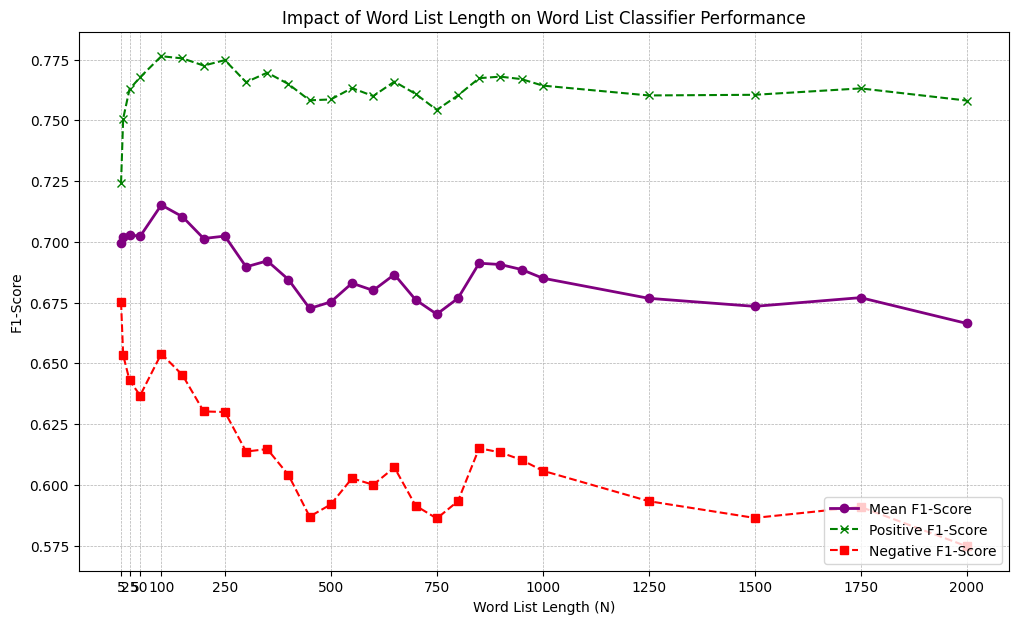

In [24]:
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.metrics import precision, recall, f_measure

# WORD LIST TESTING RANGE
lengths_to_test = [5, 10, 25] + [N for N in range(50, 1001, 50)] + [1250, 1500, 1750, 2000]
print(min(lengths_to_test), max(lengths_to_test))

# RESULTS STORAGE
results = {
    'length': [],
    'f1_pos': [],
    'f1_neg': [],
    'f1_mean': []
}

print("WORD LIST EXPERIEMENT")
print("-" * 50)

# EXPERIEMENT LOOP
for WORD_LIST_LENGTH in lengths_to_test:

    # 'final_word_counts' is the worded word list from Q1
    exp_pos_list = final_word_counts[-WORD_LIST_LENGTH:]
    exp_neg_list = final_word_counts[:WORD_LIST_LENGTH]

    exp_pos_list.sort(key=lambda item: item[1], reverse=True) # high to low
    
    # WORLD LIST CLASSIFIER INIT
    wlc = ReviewClassifer(exp_pos_list, exp_neg_list)
    
    refsets = defaultdict(set)
    testsets = defaultdict(set)
    
    # TEST SET 
    for i, (features, label) in enumerate(testing_data):
        
        predicted_label = wlc.classify(features)
            
        refsets[label].add(i)
        testsets[predicted_label].add(i)
        
    # EVALUATION METRICS (F1)
    F_pos = f_measure(refsets['pos'], testsets['pos'])
    F_neg = f_measure(refsets['neg'], testsets['neg'])
    
    # Replace None with 0.0 if a class was never predicted (e.g., if F1 calculation fails)
    F_pos = F_pos if F_pos is not None else 0.0
    F_neg = F_neg if F_neg is not None else 0.0
    
    # CALC F1 MEAN BETWEEN POSITIVE AND NEGATIVE
    F_mean = (F_pos + F_neg) / 2
    
    # STORE RESULTS
    results['length'].append(WORD_LIST_LENGTH)
    results['f1_pos'].append(F_pos)
    results['f1_neg'].append(F_neg)
    results['f1_mean'].append(F_mean)

    print(f"Length N={WORD_LIST_LENGTH:4}: Mean F1 = {F_mean:.4f} (Pos F1: {F_pos:.4f}, Neg F1: {F_neg:.4f})")

print("-" * 50)
print("EXPERIEMENT COMPLETE")

# VISUALISATION
plt.figure(figsize=(12, 7))

custom_xticks = [5, 25, 50, 100, 250] + [i for i in range(500, 2001, 250)]
plt.xticks(custom_xticks)

plt.plot(results['length'], results['f1_mean'], marker='o', label='Mean F1-Score', color='purple', linewidth=2)
plt.plot(results['length'], results['f1_pos'], marker='x', linestyle='--', label='Positive F1-Score', color='green')
plt.plot(results['length'], results['f1_neg'], marker='s', linestyle='--', label='Negative F1-Score', color='red')

plt.title('Impact of Word List Length on Word List Classifier Performance')
plt.xlabel('Word List Length (N)')
plt.ylabel('F1-Score')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')
plt.show()

## Design Decisions, Results and Discussion (Word Count: 352)

This experiment's aim is to determine how varying the Word List length impacts the classifiers performance and to the extent that it can be treated as a hyperparameter to optimize. 

Our independent variable is the Word List’s length, N. I chose to vary the increments of N’s tested, using a more granular range around the original length (N=10), a uniformly spaced mid range from N=50 to N=1000 in 50-stepped increments and an extended final range from N=1000 to N=2000 in 250-stepped increments. The initial range is used to check for any sensitivity around the arbitrary starting point, the mid range for gathering overall trend and the final range to confirm the existence of a long-term trend. 

The dependent variable is the mean F1-Score. This gives the most balanced performance view over Precision (correctness) and Recall (coverage). 

The code implementation picks up from Q1 and intercepts the sorted differential word list, slices new sentiment world lists of N length and evaluates on the untouched `testing_data`

The results of the experiment clearly identify N=100 as the optimal performance range as per the Mean F1-Score. It showed a steadily increasing F1-Score from N=10 to N=100 and sustained degradation where N>100, continuing well into the largest N values. 

For the negative class, N=100’s F1-Score (65.25%) was very similar to N=10 (65.34%). However, the F1-Score for the positive class improved to 77.47% from 75.07%. Given the underlying feature imbalance towards positive sentiment, an improvement in positive classification without degradation of the negative capabilities implies the classifier has improved on its ability to generalize unseen data.

Increasing the world list length from N=10 to N=100 allows for the inclusion of more words that have a distinct differential between positive and negative usage, providing the classifier with more evidence to correctly score reviews. Conversely, the sustained degradation after N=100 suggests a tipping point where the feature list begins to include words with a less distinct differential which introduces noise and dilutes the sentiment signal, leading to more errors and worse performance.

## 5b) Would you recommend a wordlist classifier or a Naive Bayes classifier for future work in this area? Justify your answer. (Word Count: 329)

For our research area, my recommendation would be a WLC rather than an NB due the inherent bias/imbalance towards positive features in the underlying data. 

The NB is a frequency based algorithm hence is by definition unsuitable for this task with mismatched frequencies. The constrained nature of a WLC behaves as a regularizer which gives it an advantage when applied to noisy, high dimensional data.  

In Q4 we found that the WLC outperformed the NB on the test set but additionally we found in Q5a that we can further optimize the performance using either N-length hyperparameter. 

As part of our experiment we found that continually increasing N leads to a degradation of performance. As we increase N we are increasing the number of features, which in turn is what causes the NB to perform poorly. Feature abundance is a fundamental problem for this task and some sort of regularization is a solution. 

Naive Bayes is adapted from Bayes Theorem using an assumption of independence, making it computationally a product of all probabilities. In a large corpus this leads to excessive noise and vulnerability to any underlying bias in the data making it unsuitable for the task at hand. 

One solution may be to reduce the number of features in the data fed into an NB classifier. Below I construct another NB classifier, this time using lemmatization as a preprocessing step in an attempt to reduce total features. This resulted in a mean F1-Score of 58.95% which is worse than the original NB. This shows that an NB classifier is at the mercy of feature abundance but is also sensitive to information loss. 

To summarize, the approach we use must be able to handle and tackle the problems faced in the underlying data distribution which is high-dimension, noisy and contains low-quality features. Therefore, an NB classifier is inappropriate and a WLC approach allows for more flexibility and a tailored approach through optimizing the construction of the World Lists. 

#### Lemmanization Naive Bayes (5b Supporting Material)

In [59]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lukebirkett/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [60]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK components if not already done
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Converts a Treebank POS tag (used by nltk.pos_tag) to a 
    WordNet POS tag (needed by WordNetLemmatizer).
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # Default to Noun if unsure

def preprocess_and_lemmatize(token_list: list, stop_words: list):
    """
    Applies case normalization, removes non-alpha tokens, removes stopwords, 
    and applies POS-aware lemmatization.
    """
    cleaned_tokens = [token.lower() for token in token_list if token.isalpha() and token.lower() not in stop_words]
    
    # 1. Get POS tags for the cleaned tokens
    tagged_tokens = nltk.pos_tag(cleaned_tokens)
    
    # 2. Apply POS-aware lemmatization
    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        w_net_pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=w_net_pos)
        lemmatized_tokens.append(lemma)
        
    return lemmatized_tokens

# Define stop words list again
stop = stopwords.words('english')

In [61]:
# Apply new preprocessing and feature extraction to the training data
lemmatized_featuresets = [
    (extract_features(preprocess_and_lemmatize(words, stop)), label)
    for (words, label) in training_data
]

# Apply to the testing data for evaluation
lemmatized_test_featuresets = [
    (extract_features(preprocess_and_lemmatize(words, stop)), label)
    for (words, label) in testing_data
]

print(f"Total lemmatized training feature sets: {len(lemmatized_featuresets)}")

Total lemmatized training feature sets: 1400


In [62]:
from nltk.classify import NaiveBayesClassifier
from collections import defaultdict
from nltk.metrics import precision, recall, f_measure
from nltk.classify.util import accuracy

# Train the new Naive Bayes Classifier
nb_lem_classifier = NaiveBayesClassifier.train(lemmatized_featuresets)

print("\nSuccessfully trained Lemmatized Naive Bayes Classifier.")
nb_lem_classifier.show_most_informative_features(10)

# Evaluation
refsets_lem = defaultdict(set)
testsets_lem = defaultdict(set)

for i, (features, label) in enumerate(lemmatized_test_featuresets):
    predicted_label = nb_lem_classifier.classify(features)
    refsets_lem[label].add(i)
    testsets_lem[predicted_label].add(i)

# ACCURACY
acc_lem = accuracy(nb_lem_classifier, lemmatized_test_featuresets)
print("\n" + "=" * 50)
print(f"Lemmatized Naive Bayes Classifier Evaluation (Accuracy: {acc_lem:.4f})")
print("=" * 50)

# PRECISION, RECALL, F1
for label in nb_lem_classifier.labels():
    P_lem = precision(refsets_lem[label], testsets_lem[label])
    R_lem = recall(refsets_lem[label], testsets_lem[label])
    F_lem = f_measure(refsets_lem[label], testsets_lem[label])
    
    print(f"Metrics for Class '{label}':")
    print(f"  Precision: {P_lem:.4f}")
    print(f"  Recall:    {R_lem:.4f}")
    print(f"  F1-Score:  {F_lem:.4f}")
    print("-" * 50)


Successfully trained Lemmatized Naive Bayes Classifier.
Most Informative Features
               mesmerize = True              pos : neg    =     13.0 : 1.0
                weakness = True              pos : neg    =     12.3 : 1.0
            breathtaking = True              pos : neg    =     11.0 : 1.0
                  muddle = True              neg : pos    =     10.3 : 1.0
                    bold = True              pos : neg    =      9.7 : 1.0
                  elliot = True              pos : neg    =      9.7 : 1.0
                seamless = True              pos : neg    =      9.7 : 1.0
              degenerate = True              neg : pos    =      9.0 : 1.0
                 forrest = True              pos : neg    =      9.0 : 1.0
                  hatred = True              pos : neg    =      9.0 : 1.0

Lemmatized Naive Bayes Classifier Evaluation (Accuracy: 0.6383)
Metrics for Class 'pos':
  Precision: 0.5819
  Recall:    0.9833
  F1-Score:  0.7311
-----------------